In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import os
import re
import wfdb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ptb-xl.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19338_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19342_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardio

In [ ]:
import torchaudio
import torch.nn.functional as F

sample_rate = 100
waveform = torch.randn(12,1000)

# 원하는 spectrogram 크기 설정
n_mels = 20
hop_length = 21  # 임의의 값, 조정 가능
win_length = 39  # 임의의 값, 조정 가능

# Mel spectrogram 계산
mel_specgram_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=win_length,
    hop_length=hop_length,
    win_length=win_length,
    n_mels=n_mels
)

stft_spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=win_length,
    hop_length=hop_length,
    win_length=win_length
)

mel_specgram = mel_specgram_transform(waveform)
stft = stft_spectrogram(waveform)
# 결과 확인
print(mel_specgram.shape, stft.shape)  # (n_mels, T), 여기서 T는 spectrogram의 시간 차원

torch.Size([12, 20, 48]) torch.Size([12, 20, 48])


In [ ]:
diagnostics={"NORM":['NORM','CSD'],
             "STTC":['NDT', 'NST_', 'DIG', 'LNGQT', 'ISC_', 'ISCAL', 'ISCIN', 'ISCIL', 'ISCAS', 'ISCLA', 'ANEUR', 'EL', 'ISCAN' ],
             "MI":['IMI', 'ASMI', 'ILMI', 'AMI', 'ALMI', 'INJAS', 'LMI', 'INJAL', 'IPLMI', 'IPMI', 'INJIN', 'INJLA', 'PMI', 'INJIL'],
             "HYP":['LVH', 'LAO/LAE', 'RVH', 'RAO/RAE', 'SEHYP'],
             "CD":['LAFB', 'IRBBB', '1AVB', 'IVCD', 'CRBBB', 'CLBBB', 'LPFB', 'WPW', 'ILBBB', '3AVB', '2AVB'],
             "OTHER":['AFLT', 'AFIB', 'PSVT', 'STACH', 'PVC', 'PACE', 'PAC']
            }

In [ ]:
diagnostics['MI']

['IMI',
 'ASMI',
 'ILMI',
 'AMI',
 'ALMI',
 'INJAS',
 'LMI',
 'INJAL',
 'IPLMI',
 'IPMI',
 'INJIN',
 'INJLA',
 'PMI',
 'INJIL']

In [ ]:
ecg_data=pd.read_csv('ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv')
ecg_data.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [ ]:
ecg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21837 entries, 0 to 21836
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ecg_id                        21837 non-null  int64  
 1   patient_id                    21837 non-null  float64
 2   age                           21748 non-null  float64
 3   sex                           21837 non-null  int64  
 4   height                        6983 non-null   float64
 5   weight                        9429 non-null   float64
 6   nurse                         20328 non-null  float64
 7   site                          21819 non-null  float64
 8   device                        21837 non-null  object 
 9   recording_date                21837 non-null  object 
 10  report                        21837 non-null  object 
 11  scp_codes                     21837 non-null  object 
 12  heart_axis                    13332 non-null  object 
 13  i

In [ ]:
#Merging the diagnosis into a superclass:
labels=[]
discard=[]
for index in range(ecg_data.shape[0]):
    counter=0
    temp_diag=ecg_data['scp_codes'][index]
    temp_diag=re.sub('{',"",str(temp_diag))
    temp_diag=re.sub('}',"",temp_diag)
    temp_diag=temp_diag.split(',')
    len_diag=len(temp_diag)
    for idx in range(len_diag):
        temp_d=temp_diag[idx]
        temp_d=temp_d.split(':')[0]
        temp_d=re.sub(r'[^\w\s]',"",temp_d)
        if temp_d in diagnostics['NORM']:
            label=0
            counter=1
        elif temp_d in diagnostics['STTC']:
            label=1
            counter=1
        elif temp_d in diagnostics['MI']:
            label=2
            counter=1
        elif temp_d in diagnostics['HYP']:
            label=3
            counter=1
        elif temp_d in diagnostics['CD']:
            label=4
            counter=1
        elif temp_d in diagnostics['OTHER']:
            label=5
            counter=1
        else:
            label=100
        labels.append(label)
    if counter==0:
        discard.append(index)

In [ ]:
#Merging the diagnosis into a superclass:
labels=[]
discard=[]
for index in range(ecg_data.shape[0]):
    counter=0
    temp_diag=ecg_data['scp_codes'][index]
    temp_diag=re.sub('{',"",str(temp_diag))
    temp_diag=re.sub('}',"",temp_diag)
    temp_diag=temp_diag.split(',')
    len_diag=len(temp_diag)
    for idx in range(len_diag):
        temp_d=temp_diag[idx]
        temp_d=temp_d.split(':')[0]
        temp_d=re.sub(r'[^\w\s]',"",temp_d)
        if temp_d in diagnostics['NORM']:
            label=0
            counter=1
        elif temp_d in diagnostics['STTC']:
            label=1
            counter=1
        elif temp_d in diagnostics['MI']:
            label=1
            counter=1
        elif temp_d in diagnostics['HYP']:
            label=1
            counter=1
        elif temp_d in diagnostics['CD']:
            label=1
            counter=1
        elif temp_d in diagnostics['OTHER']:
            label=1
            counter=1
        else:
            label=100
        labels.append(label)
    if counter==0:
        discard.append(index)

In [ ]:
final_labels=[]
for index in range(len(labels)):
    if labels[index]!=100:
        final_labels.append(labels[index])

In [ ]:
final_data=ecg_data.drop(axis=0,index=discard)

In [ ]:
final_data['Labels']=final_labels

In [ ]:
final_data.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,Labels
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,0
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,0
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,0
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,0
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,0


<Axes: xlabel='Labels', ylabel='count'>

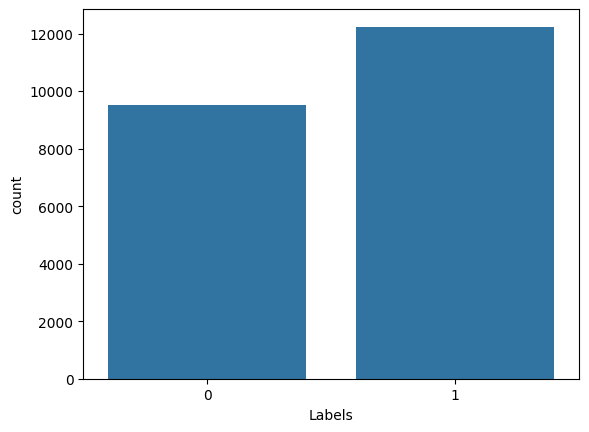

In [ ]:
sns.countplot(data=final_data,x='Labels')

In [ ]:
class ECG_Data(Dataset):
    def __init__(self,dataframe):
        self.data=dataframe
        self.n_mels = 20
        self.hop_length = 21  # 임의의 값, 조정 가능
        self.win_length = 39  # 임의의 값, 조정 가능
        self.mel_specgram_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=100,
            n_fft=self.win_length,
            hop_length=self.hop_length,
            win_length=self.win_length,
            n_mels=self.n_mels,
            normalized=True,
            power=1
        )
        self.stft_spectrogram = torchaudio.transforms.Spectrogram(
            n_fft=self.win_length,
            hop_length=self.hop_length,
            win_length=self.win_length,
            normalized=True,
            power=1
        )

    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self,idx):
        path='ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'+self.data['filename_lr'][idx]
        file_audio=wfdb.rdsamp(path)
        data=file_audio
        data_new=np.array(data[0])
        data_new=np.transpose(data_new,(1,0))
        #data_final=data_new[7]
        data_final = data_new
        label=self.data['Labels'][idx]
        data_final = torch.Tensor(data_final)
        #data_final=torch.Tensor(data_final).view(1, 12, 1000)

        #data_final = self.stft_spectrogram(data_final)
        return data_final, label

In [ ]:
ECG_train = final_data[final_data['strat_fold'].isin([1, 2, 3, 4, 5, 6, 7, 8])].reset_index(drop=True)
ECG_val = final_data[final_data['strat_fold'] == 9].reset_index(drop=True)
ECG_test = final_data[final_data['strat_fold'] == 10].reset_index(drop=True)

ECG_train = ECG_train[ECG_train['Labels'].isin([0,1])].reset_index(drop=True)
ECG_val = ECG_val[ECG_val['Labels'].isin([0,1])].reset_index(drop=True)
ECG_test = ECG_test[ECG_test['Labels'].isin([0,1])].reset_index(drop=True)

# ECG_train=ECG_train.reset_index()
# ECG_test=ECG_test.reset_index()

train_dataset = ECG_Data(ECG_train)
train_loader = DataLoader(train_dataset,batch_size=64, shuffle=True)

val_dataset=ECG_Data(ECG_val)
val_loader=DataLoader(val_dataset,batch_size=64, shuffle=True)

test_dataset=ECG_Data(ECG_test)
test_loader=DataLoader(test_dataset,batch_size=64, shuffle=True)

first_batch, label = next(iter(train_loader))

print(f"Batch shape: {first_batch.shape}")

"""
for i in range(12):
    print(f'channel {i}: {torch.min(first_batch[:, i])}, {torch.max(first_batch[:, i])}')
"""

Batch shape: torch.Size([64, 12, 1000])


"\nfor i in range(12):\n    print(f'channel {i}: {torch.min(first_batch[:, i])}, {torch.max(first_batch[:, i])}')\n"

In [ ]:
ECG_train = final_data[final_data['strat_fold'].isin([1, 2, 3, 4, 5, 6, 7, 8])].reset_index(drop=True)
ECG_val = final_data[final_data['strat_fold'] == 9].reset_index(drop=True)
ECG_test = final_data[final_data['strat_fold'] == 10].reset_index(drop=True)

ECG_train = ECG_train[ECG_train['Labels'].isin([0,1,2,3,4])].reset_index(drop=True)
ECG_val = ECG_val[ECG_val['Labels'].isin([0,1,2,3,4])].reset_index(drop=True)
ECG_test = ECG_test[ECG_test['Labels'].isin([0,1,2,3,4])].reset_index(drop=True)

# ECG_train=ECG_train.reset_index()
# ECG_test=ECG_test.reset_index()

train_dataset = ECG_Data(ECG_train)
train_loader = DataLoader(train_dataset,batch_size=64, shuffle=True)

val_dataset=ECG_Data(ECG_val)
val_loader=DataLoader(val_dataset,batch_size=64, shuffle=True)

test_dataset=ECG_Data(ECG_test)
test_loader=DataLoader(test_dataset,batch_size=64, shuffle=True)

first_batch, label = next(iter(train_loader))

print(f"Batch shape: {first_batch.shape}")

"""
for i in range(12):
    print(f'channel {i}: {torch.min(first_batch[:, i])}, {torch.max(first_batch[:, i])}')
"""

Batch shape: torch.Size([64, 12, 1000])


"\nfor i in range(12):\n    print(f'channel {i}: {torch.min(first_batch[:, i])}, {torch.max(first_batch[:, i])}')\n"

In [ ]:
len(train_loader), len(val_loader), len(test_loader)

(272, 35, 35)


1. Weighted cross entropy
2. conv_first
3. Add time axis stride in conv_first and conv_head

In [ ]:
tau = 1
in_channel = 12
model = BCResNets(int(tau * 8), 5, in_channel)
if in_channel == 1:
    sample = torch.randn(1,12,1000)
else:
    sample = torch.randn(1,12,1000)
    #sample = torch.randn(1,12,20,48)
print(sample.shape)
pred = model(sample)
pred.shape

torch.Size([1, 12, 1000])


torch.Size([1, 5])

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
import numpy as np

# 클래스 별 라벨 수
label_counts = np.array([7607, 2237, 4353, 1003, 1841])

# 각 클래스 별 가중치 계산
total_samples = np.sum(label_counts)
class_weights = total_samples / (label_counts * len(label_counts))

print(class_weights)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor(class_weights).float().to(device)

[0.4480347  1.52355834 0.78295428 3.39800598 1.85127648]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nSamples = [887, 6130, 480, 317, 972, 101, 128]
normedWeights = [1 - (x / sum(label_counts)) for x in label_counts]
class_weights = torch.FloatTensor(normedWeights).to(device)
print(class_weights)

tensor([0.5536, 0.8687, 0.7446, 0.9411, 0.8920], device='cuda:0')


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

tau = 3
in_channel = 12
model = BCResNets(int(tau * 8), 5, in_channel).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/bcresnet3_best_weights_5.pth'))

# 모델을 평가 모드로 설정
model.eval()
from sklearn.metrics import confusion_matrix

# 모델의 예측과 실제 레이블 간의 혼동 행렬 계산 함수
def calculate_confusion_matrix(model, data_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, label in data_loader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            predictions = torch.argmax(output, dim=1)
            y_true.extend(label.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
    return confusion_matrix(y_true, y_pred)

# 테스트 데이터셋에 대한 혼동 행렬 계산
test_confusion_matrix = calculate_confusion_matrix(model, test_loader, device)
print("Confusion Matrix for Test Data:")
print(test_confusion_matrix)


Using cuda device
Confusion Matrix for Test Data:
[[863  30  44   8  19]
 [ 46 176  39  14   9]
 [ 56  37 424   4  26]
 [ 25  23  19  43   7]
 [ 47  10  48   7 133]]


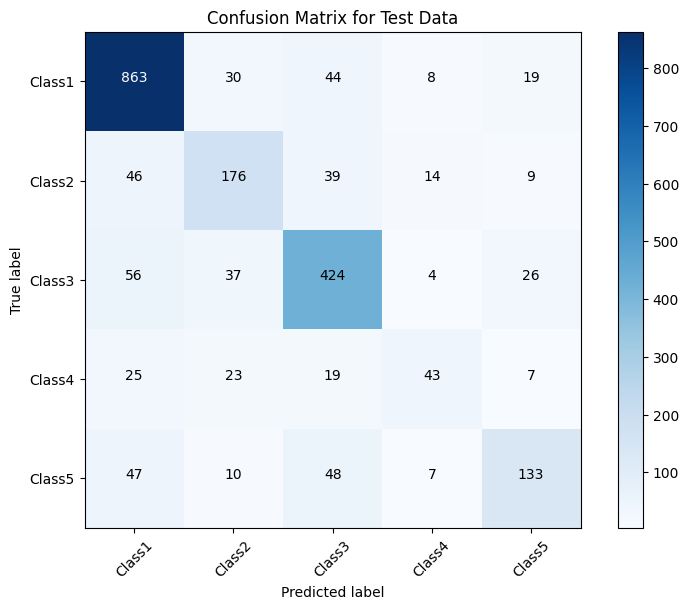

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

# 혼동 행렬 시각화 함수
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 클래스 레이블 정의
class_names = ['Class1', 'Class2', 'Class3', 'Class4', 'Class5']

# 테스트 데이터셋에 대한 혼동 행렬 계산
test_confusion_matrix = calculate_confusion_matrix(model, test_loader, device)

# 혼동 행렬 시각화
plot_confusion_matrix(test_confusion_matrix, classes=class_names, title='Confusion Matrix for Test Data')


In [ ]:
from sklearn.metrics import roc_auc_score

# 클래스별 AUC 계산 함수
def calculate_class_auc(model, data_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, label in data_loader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            probabilities = torch.softmax(output, dim=1)
            y_true.extend(label.cpu().numpy())
            y_pred.extend(probabilities.cpu().numpy())

    # AUC를 저장할 딕셔너리 초기화
    class_auc = {}
    for i in range(len(class_names)):
        true_labels = np.array(y_true) == i
        class_probabilities = np.array(y_pred)[:, i]
        class_auc[class_names[i]] = roc_auc_score(true_labels, class_probabilities)
    return class_auc

# 테스트 데이터셋에 대한 클래스별 AUC 계산
class_auc = calculate_class_auc(model, test_loader, device)

# 클래스별 AUC 출력
for class_name, auc_value in class_auc.items():
    print(f"AUC for {class_name}: {auc_value:.4f}")


AUC for Class1: 0.9484
AUC for Class2: 0.9227
AUC for Class3: 0.9284
AUC for Class4: 0.9067
AUC for Class5: 0.9083


In [ ]:
model = BCResNets(int(tau * 8), 5, in_channel).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/bcresnet3_best_weights_5.pth'))

torch.save({
    'model_state_dict': model.state_dict(),
    'classifier_state_dict': model.classifier.state_dict()
}, 'model_checkpoint.pth')

In [ ]:
checkpoint = torch.load('model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])

num_classes = 1
# classifier 부분 수정
model.classifier = nn.Sequential(
    nn.Conv2d(
        model.c[-2], model.c[-2], (5, 5), bias=False, groups=model.c[-2], padding=(0, 2)
    ),
    nn.Conv2d(model.c[-2], model.c[-1], 1, bias=False),
    nn.BatchNorm2d(model.c[-1]),
    nn.ReLU(True),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Conv2d(model.c[-1], num_classes, 1),
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
num_epochs = 2
tau = 3
#model = BCResNets(int(tau * 8), 5).to(device)
in_channel = 12
best_test_auc = float("-inf")

checkpoint = torch.load('model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])

num_classes = 1
# classifier 부분 수정
model.classifier = nn.Sequential(
    nn.Conv2d(
        model.c[-2], model.c[-2], (5, 5), bias=False, groups=model.c[-2], padding=(0, 2)
    ),
    nn.Conv2d(model.c[-2], model.c[-1], 1, bias=False),
    nn.BatchNorm2d(model.c[-1]),
    nn.ReLU(True),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Conv2d(model.c[-1], num_classes, 1),
)

n_step_warmup = len(train_loader) * warmup_epoch
total_iter = len(train_loader) * num_epochs
iterations = 0
init_lr = 1e-2
lr_lower_limit = 0

optim = torch.optim.Adam(model.parameters(), lr=init_lr)
#loss_fn = torch.nn.CrossEntropyLoss(class_weights)
loss_fn = torch.nn.BCELoss()
#loss_fn = torch.nn.CrossEntropyLoss()

def acc(op, labels):
    op = torch.softmax(op, dim=1)
    _, preds = torch.max(op, dim=1)
    return (preds == labels).float().mean()

for epoch in range(num_epochs):
    model.train()
    train_accuracy = []
    train_loss_sum = 0
    for data, label in train_loader:

        data, label = data.to(device), label.to(device)

        optim.zero_grad()
        output = model(data)
        loss_value = loss_fn(output, label)
        loss_value.backward()
        optim.step()

        train_loss_sum += loss_value.item()
        train_accuracy.append(acc(output, label).item())

    avg_train_accuracy = np.mean(train_accuracy)
    avg_train_loss = train_loss_sum / len(train_loader)
    print(f'Epoch: {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.2f}%')

    model.eval()
    test_accuracy = []
    test_loss_sum = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)

            output = model(data)
            loss_value = loss_fn(output, label)

            test_loss_sum += loss_value.item()
            test_accuracy.append(acc(output, label).item())

            y_true.extend(label.cpu().numpy())
            y_pred.extend(torch.softmax(output, dim=1).cpu().numpy())

    avg_test_accuracy = np.mean(test_accuracy)
    avg_test_loss = test_loss_sum / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.2f}%')

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate macro AUC
    macro_auc_ovo = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovo')
    macro_auc_ovr = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')
    if macro_auc_ovr > best_test_auc:
      torch.save(model.state_dict(), f'{dd}model.pth')
    print(f'Macro AUC: {macro_auc_ovo:.4f}, {macro_auc_ovr:.4f}')

Using cuda device
Epoch: 1/100, Training Loss: 0.9620, Training Accuracy: 0.66%
Test Loss: 1.0374, Test Accuracy: 0.67%
Macro AUC: 0.8481, 0.8737
Epoch: 2/100, Training Loss: 0.8012, Training Accuracy: 0.72%
Test Loss: 0.8491, Test Accuracy: 0.71%
Macro AUC: 0.8839, 0.9001
Epoch: 3/100, Training Loss: 0.7557, Training Accuracy: 0.74%
Test Loss: 0.8308, Test Accuracy: 0.72%
Macro AUC: 0.8936, 0.9056
Epoch: 4/100, Training Loss: 0.7118, Training Accuracy: 0.75%
Test Loss: 0.8120, Test Accuracy: 0.73%
Macro AUC: 0.8910, 0.9099
Epoch: 5/100, Training Loss: 0.6880, Training Accuracy: 0.76%
Test Loss: 0.8394, Test Accuracy: 0.73%
Macro AUC: 0.8909, 0.9129
Epoch: 6/100, Training Loss: 0.6730, Training Accuracy: 0.77%
Test Loss: 0.7800, Test Accuracy: 0.73%
Macro AUC: 0.9017, 0.9175
Epoch: 7/100, Training Loss: 0.6622, Training Accuracy: 0.77%
Test Loss: 0.7656, Test Accuracy: 0.74%
Macro AUC: 0.9028, 0.9204
Epoch: 8/100, Training Loss: 0.6509, Training Accuracy: 0.78%
Test Loss: 0.8361, Test 

KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
num_epochs = 100
tau = 1
#model = BCResNets(int(tau * 8), 5).to(device)
in_channel = 12
model = BCResNets(int(tau * 8), 1, in_channel).to(device)
warmup_epoch = 5
n_step_warmup = len(train_loader) * warmup_epoch
total_iter = len(train_loader) * num_epochs
iterations = 0
init_lr = 1e-1
lr_lower_limit = 0
best_test_auc = float("-inf")

optim = torch.optim.Adam(model.parameters(), lr=init_lr)
#loss_fn = torch.nn.CrossEntropyLoss(class_weights)
#loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.BCELoss()

def acc(op, labels):
    op = torch.softmax(op, dim=1)
    _, preds = torch.max(op, dim=1)
    return (preds == labels).float().mean()

for epoch in range(num_epochs):
    model.train()
    train_accuracy = []
    train_loss_sum = 0
    for data, label in train_loader:

        data, label = data.to(device), label.to(device)

        optim.zero_grad()
        output = torch.sigmoid(model(data))
        loss_value = loss_fn(output.squeeze(-1), label.float())
        loss_value.backward()
        optim.step()

        train_loss_sum += loss_value.item()
        train_accuracy.append(acc(output, label).item())

    avg_train_accuracy = np.mean(train_accuracy)
    avg_train_loss = train_loss_sum / len(train_loader)
    print(f'Epoch: {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.2f}%')

    model.eval()
    test_accuracy = []
    test_loss_sum = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)

            output = torch.sigmoid(model(data))
            loss_value = loss_fn(output.squeeze(-1), label.float())

            test_loss_sum += loss_value.item()
            test_accuracy.append(acc(output, label).item())

            y_true.extend(label.cpu().numpy())
            y_pred.extend(torch.sigmoid(output).cpu().numpy())

    avg_test_accuracy = np.mean(test_accuracy)
    avg_test_loss = test_loss_sum / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.2f}%')

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate macro AUC
    macro_auc_ovo = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovo')
    macro_auc_ovr = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')
    if macro_auc_ovr > best_test_auc:
      torch.save(model.state_dict(), '/content/drive/MyDrive/bcresnet_best_model_weights_binary_norm.pth')

    print(f'Macro AUC: {macro_auc_ovo:.4f}, {macro_auc_ovr:.4f}')

Using cuda device
Epoch: 1/100, Training Loss: 0.4501, Training Accuracy: 0.44%
Test Loss: 0.5103, Test Accuracy: 0.44%
Macro AUC: 0.8881, 0.8881
Epoch: 2/100, Training Loss: 0.3814, Training Accuracy: 0.44%
Test Loss: 0.8684, Test Accuracy: 0.44%
Macro AUC: 0.8851, 0.8851
Epoch: 3/100, Training Loss: 0.3608, Training Accuracy: 0.44%
Test Loss: 0.3699, Test Accuracy: 0.44%
Macro AUC: 0.9130, 0.9130
Epoch: 4/100, Training Loss: 0.3516, Training Accuracy: 0.44%
Test Loss: 0.3793, Test Accuracy: 0.44%
Macro AUC: 0.9051, 0.9051
Epoch: 5/100, Training Loss: 0.3426, Training Accuracy: 0.44%
Test Loss: 0.5257, Test Accuracy: 0.44%
Macro AUC: 0.9078, 0.9078
Epoch: 6/100, Training Loss: 0.3358, Training Accuracy: 0.44%
Test Loss: 0.3659, Test Accuracy: 0.44%
Macro AUC: 0.9216, 0.9216
Epoch: 7/100, Training Loss: 0.3318, Training Accuracy: 0.44%
Test Loss: 0.3468, Test Accuracy: 0.44%
Macro AUC: 0.9229, 0.9229
Epoch: 8/100, Training Loss: 0.3255, Training Accuracy: 0.44%
Test Loss: 0.3626, Test 

KeyboardInterrupt: 

In [ ]:
y_true, y_pred

(array([1, 0, 1, ..., 0, 1, 1]),
 array([[1.11017074e-03, 9.98887002e-01, 5.62518267e-07, 1.40640918e-06,
         8.55325823e-07],
        [2.87193179e-01, 7.08182931e-01, 1.19123654e-03, 1.73477526e-03,
         1.69790862e-03],
        [5.41158894e-04, 9.99458492e-01, 6.44479883e-08, 1.83835596e-07,
         1.04142764e-07],
        ...,
        [8.84650290e-01, 1.15050182e-01, 7.37605878e-05, 9.22017862e-05,
         1.33564812e-04],
        [1.06862046e-01, 8.92594278e-01, 1.29015825e-04, 2.14572952e-04,
         2.00073977e-04],
        [2.14978039e-01, 7.83107400e-01, 4.70018131e-04, 7.38278264e-04,
         7.06315273e-04]], dtype=float32))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
num_epochs = 100
tau = 1
#model = BCResNets(int(tau * 8), 5).to(device)
in_channel = 12
model = BCResNets(int(tau * 8), 5, in_channel).to(device)
warmup_epoch = 5
n_step_warmup = len(train_loader) * warmup_epoch
total_iter = len(train_loader) * num_epochs
iterations = 0
init_lr = 1e-2
lr_lower_limit = 0

optim = torch.optim.Adam(model.parameters(), lr=init_lr)
loss_fn = torch.nn.CrossEntropyLoss(class_weights)

def acc(op, labels):
    op = torch.softmax(op, dim=1)
    _, preds = torch.max(op, dim=1)
    return (preds == labels).float().mean()

for epoch in range(num_epochs):
    model.train()
    train_accuracy = []
    train_loss_sum = 0
    for data, label in train_loader:

        data, label = data.to(device), label.to(device)

        optim.zero_grad()
        output = model(data)
        loss_value = loss_fn(output, label)
        loss_value.backward()
        optim.step()

        train_loss_sum += loss_value.item()
        train_accuracy.append(acc(output, label).item())

    avg_train_accuracy = np.mean(train_accuracy)
    avg_train_loss = train_loss_sum / len(train_loader)
    print(f'Epoch: {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.2f}%')

    model.eval()
    test_accuracy = []
    test_loss_sum = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)

            output = model(data)
            loss_value = loss_fn(output, label)

            test_loss_sum += loss_value.item()
            test_accuracy.append(acc(output, label).item())

            y_true.extend(label.cpu().numpy())
            y_pred.extend(torch.softmax(output, dim=1).cpu().numpy())

    avg_test_accuracy = np.mean(test_accuracy)
    avg_test_loss = test_loss_sum / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.2f}%')

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate macro AUC
    macro_auc_ovo = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovo')
    macro_auc_ovr = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')
    print(f'Macro AUC: {macro_auc_ovo:.4f}, {macro_auc_ovr:.4f}')

Using cuda device
Epoch: 1/100, Training Loss: 1.0751, Training Accuracy: 0.62%
Test Loss: 1.0805, Test Accuracy: 0.59%
Macro AUC: 0.8391, 0.8426
Epoch: 2/100, Training Loss: 0.8630, Training Accuracy: 0.70%
Test Loss: 1.0097, Test Accuracy: 0.68%
Macro AUC: 0.8630, 0.8806
Epoch: 3/100, Training Loss: 0.8015, Training Accuracy: 0.72%
Test Loss: 1.0233, Test Accuracy: 0.62%
Macro AUC: 0.8735, 0.8807
Epoch: 4/100, Training Loss: 0.7630, Training Accuracy: 0.74%
Test Loss: 0.9194, Test Accuracy: 0.69%
Macro AUC: 0.8814, 0.8989
Epoch: 5/100, Training Loss: 0.7420, Training Accuracy: 0.74%
Test Loss: 0.8544, Test Accuracy: 0.71%
Macro AUC: 0.8864, 0.8983
Epoch: 6/100, Training Loss: 0.7257, Training Accuracy: 0.75%
Test Loss: 0.7971, Test Accuracy: 0.74%
Macro AUC: 0.8931, 0.9112
Epoch: 7/100, Training Loss: 0.7125, Training Accuracy: 0.76%
Test Loss: 0.8914, Test Accuracy: 0.70%
Macro AUC: 0.8841, 0.9063
Epoch: 8/100, Training Loss: 0.6964, Training Accuracy: 0.76%
Test Loss: 0.7780, Test 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
num_epochs = 50
#model = DecomNet().to(device)
tau = 6
model = BCResNets(int(tau * 8), 6).to(device)
warmup_epoch = 5
n_step_warmup = len(train_loader) * warmup_epoch
total_iter = len(train_loader) * num_epochs
iterations = 0
init_lr = 1e-2
lr_lower_limit = 0
best_test_auc = float("-inf")


optim = torch.optim.Adam(model.parameters(), lr=init_lr)
loss_fn = torch.nn.CrossEntropyLoss()

def acc(op, labels):
    op = torch.softmax(op, dim=1)
    _, preds = torch.max(op, dim=1)
    return (preds == labels).float().mean()

for epoch in range(num_epochs):
    model.train()
    train_accuracy = []
    train_loss_sum = 0
    for data, label in train_loader:
        iterations += 1
        if iterations < n_step_warmup:
            lr = init_lr * iterations / n_step_warmup
        else:
            lr = lr_lower_limit + 0.5 * (init_lr - lr_lower_limit) * (
                1
                + np.cos(
                    np.pi * (iterations - n_step_warmup) / (total_iter - n_step_warmup)
                )
            )
        for param_group in optim.param_groups:
            param_group["lr"] = lr

        data, label = data.to(device), label.to(device)

        optim.zero_grad()
        output = model(data)
        loss_value = loss_fn(output, label)
        loss_value.backward()
        optim.step()

        train_loss_sum += loss_value.item()
        train_accuracy.append(acc(output, label).item())

    avg_train_accuracy = np.mean(train_accuracy)
    avg_train_loss = train_loss_sum / len(train_loader)
    print(f'Epoch: {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.2f}%')

    model.eval()
    test_accuracy = []
    test_loss_sum = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)

            output = model(data)
            loss_value = loss_fn(output, label)

            test_loss_sum += loss_value.item()
            test_accuracy.append(acc(output, label).item())

            y_true.extend(label.cpu().numpy())
            y_pred.extend(torch.softmax(output, dim=1).cpu().numpy())

    avg_test_accuracy = np.mean(test_accuracy)
    avg_test_loss = test_loss_sum / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.2f}%')

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate macro AUC
    macro_auc_ovo = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovo')
    macro_auc_ovr = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')

    if macro_auc_ovr > best_test_auc:
      torch.save(model.state_dict(), '/content/best_model_weights.pth')

    print(f'Macro AUC: {macro_auc_ovo:.4f}, {macro_auc_ovr:.4f}')

Using cuda device
Epoch: 1/50, Training Loss: 1.1354, Training Accuracy: 0.59%
Test Loss: 0.9653, Test Accuracy: 0.64%
Macro AUC: 0.8588, 0.8735
Epoch: 2/50, Training Loss: 0.8549, Training Accuracy: 0.69%
Test Loss: 0.8463, Test Accuracy: 0.68%
Macro AUC: 0.8975, 0.9022
Epoch: 3/50, Training Loss: 0.7878, Training Accuracy: 0.71%
Test Loss: 0.8030, Test Accuracy: 0.71%
Macro AUC: 0.9045, 0.9119
Epoch: 4/50, Training Loss: 0.7421, Training Accuracy: 0.73%
Test Loss: 0.8200, Test Accuracy: 0.71%
Macro AUC: 0.9044, 0.9168
Epoch: 5/50, Training Loss: 0.7270, Training Accuracy: 0.73%
Test Loss: 0.7840, Test Accuracy: 0.72%
Macro AUC: 0.9081, 0.9215
Epoch: 6/50, Training Loss: 0.6829, Training Accuracy: 0.75%
Test Loss: 0.7564, Test Accuracy: 0.72%
Macro AUC: 0.9148, 0.9244
Epoch: 7/50, Training Loss: 0.6575, Training Accuracy: 0.76%
Test Loss: 0.7085, Test Accuracy: 0.75%
Macro AUC: 0.9186, 0.9285
Epoch: 8/50, Training Loss: 0.6294, Training Accuracy: 0.77%
Test Loss: 0.7306, Test Accuracy

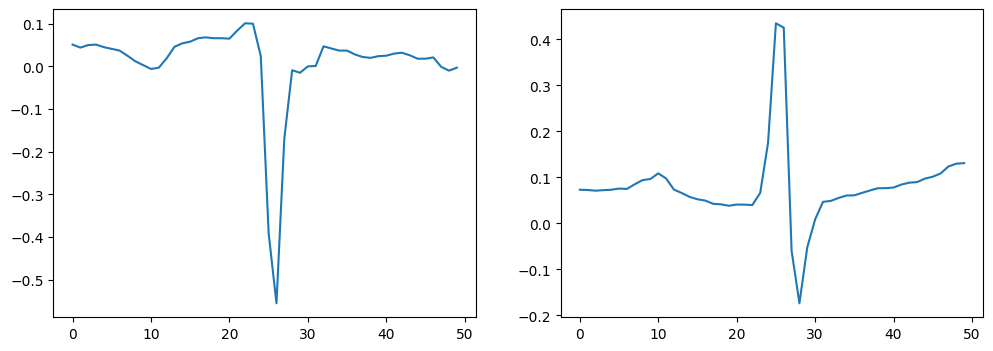

In [ ]:
idx = 1
channel = 3
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(label[idx,channel,:50].cpu())

plt.subplot(122)
plt.plot(torch.bmm(output2.permute(0, 2, 1), output1)[idx,channel,:50].cpu())

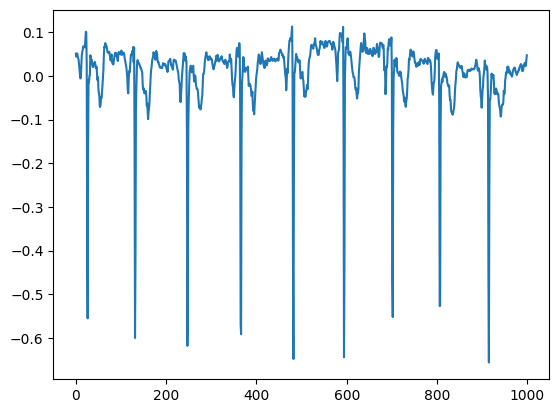

In [ ]:
plt.plot(data[idx,channel,:].cpu())

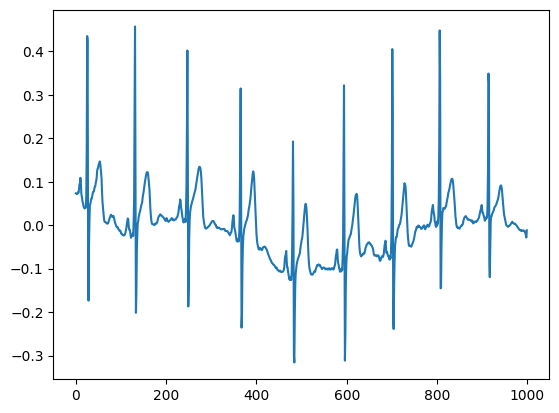

In [ ]:
plt.plot(torch.bmm(output2.permute(0, 2, 1), output1)[idx,channel,:].cpu())

In [ ]:
class ECGTransformer(nn.Module):
    def __init__(self, input_dim, model_dim=512, nhead=8, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=2048, dropout=0.1):
        super(ECGTransformer, self).__init__()

        self.model_dim = model_dim
        self.pos_encoder = PositionalEncoding(model_dim, dropout)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        self.decoder = nn.Linear(model_dim, 6)  # 6 is the number of classes
        self.src_mask = None
        self.input_linear = nn.Linear(input_dim, model_dim)  # Adapt input dimension to model dimension
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.input_linear.bias.data.zero_()
        self.input_linear.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.input_linear(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output.mean(dim=1))
        return F.log_softmax(output, dim=-1)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model = ECGTransformer(input_dim=1, model_dim=512).to(device)

optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

def acc(op, labels):
    op = torch.softmax(op, dim=1)
    _, preds = torch.max(op, dim=1)
    return (preds == labels).float().mean()

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_accuracy = []
    train_loss_sum = 0
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
        data = data.unsqueeze(-1)

        optim.zero_grad()
        output = model(data)
        loss_value = loss_fn(output, label)
        loss_value.backward()
        optim.step()

        train_loss_sum += loss_value.item()
        train_accuracy.append(acc(output, label).item())

    avg_train_accuracy = np.mean(train_accuracy)
    avg_train_loss = train_loss_sum / len(train_loader)
    print(f'Epoch: {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.2f}%')

    model.eval()
    test_accuracy = []
    test_loss_sum = 0
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            data = data.unsqueeze(-1)

            output = model(data)
            loss_value = loss_fn(output, label)

            test_loss_sum += loss_value.item()
            test_accuracy.append(acc(output, label).item())

    avg_test_accuracy = np.mean(test_accuracy)
    avg_test_loss = test_loss_sum / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.2f}%')


Using cuda device


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch: 1/10, Training Loss: 1.5533, Training Accuracy: 0.43%
Test Loss: 1.3914, Test Accuracy: 0.45%


KeyboardInterrupt: 

In [ ]:
!git clone https://github.com/hsd1503/resnet1d.git

Cloning into 'resnet1d'...
remote: Enumerating objects: 238, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 238 (delta 44), reused 40 (delta 40), pack-reused 190
Receiving objects: 100% (238/238), 11.89 MiB | 18.91 MiB/s, done.
Resolving deltas: 100% (137/137), done.
Error downloading object: trained_model/model.pth (65efeca): Smudge error: Error downloading trained_model/model.pth (65efeca3f6c445e7fdadf97c38ba28829d201b90163afea8a1f4b4b780c4a440): batch response: This repository is over its data quota. Account responsible for LFS bandwidth should purchase more data packs to restore access.

Errors logged to /content/resnet1d/.git/lfs/logs/20240421T215727.964693449.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: trained_model/model.pth: smudge filter lfs failed
You can inspect what was checked out with 'git status'
and retry with 'git restore --source=HEAD :/'



In [ ]:
!mv resnet1d/ ./

mv: 'resnet1d/' and './resnet1d' are the same file


In [ ]:
from resnet1d.resnet1d import ResNet1D

In [ ]:
from resnet1d.resnet1d import ResNet1D
base_filters = 64
filter_list=[64,160,160,400,400,1024,1024]
m_blocks_list=[2,2,2,3,3,4,4]

model = ResNet1D(
    in_channels=12,
    base_filters=base_filters,
    kernel_size=16,
    stride=2,
    groups=16,
    n_block=19,
    verbose=False,
    n_classes=5)

In [ ]:
import torch
import torch.nn as nn

def create_head1d(nf, nc, lin_ftrs=None, ps=0.5, bn_final=False, bn=True, act="relu", concat_pooling=True):
    """Create a head for a 1D convolutional model.

    Args:
        nf (int): Number of input features.
        nc (int): Number of output classes.
        lin_ftrs (Optional[List[int]]): List of fully connected layers' sizes.
        ps (float or List[float]): Dropout probability or list of probabilities for each layer.
        bn_final (bool): Whether to apply batch normalization to the final layer.
        bn (bool): Whether to apply batch normalization to each fully connected layer.
        act (str): Activation function to be used.
        concat_pooling (bool): Whether to use adaptive concatenation pooling.

    Returns:
        nn.Sequential: Head for the model.
    """
    lin_ftrs = [nf, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = [ps] if isinstance(ps, float) else ps
    act_fn = nn.ReLU(inplace=True) if act == "relu" else nn.ELU(inplace=True)
    layers = []

    pool = nn.AdaptiveAvgPool1d(1) if concat_pooling else nn.MaxPool1d(2)
    layers.append(pool)
    layers.append(nn.Flatten())

    for i in range(len(lin_ftrs)-1):
        layers.append(nn.Linear(lin_ftrs[i], lin_ftrs[i+1], bias=not bn))
        if bn:
            layers.append(nn.BatchNorm1d(lin_ftrs[i+1]))
        if i < len(lin_ftrs)-2:
            layers.append(act_fn)
            if ps[i] > 0:
                layers.append(nn.Dropout(ps[i]))

    if bn_final:
        layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))

    return nn.Sequential(*layers)

import torch
import torch.nn as nn
import torch.nn.functional as F

class InceptionBlock1d(nn.Module):
    def __init__(self, ni, nb_filters, kss, stride=1, act='linear', bottleneck_size=32):
        super(InceptionBlock1d, self).__init__()
        self.bottleneck = nn.Conv1d(ni, bottleneck_size, kernel_size=1, stride=stride) if bottleneck_size > 0 else nn.Identity()
        self.convs = nn.ModuleList([nn.Conv1d(bottleneck_size if bottleneck_size > 0 else ni, nb_filters, ks, padding=ks // 2) for ks in kss])
        self.conv_bottle = nn.Sequential(nn.MaxPool1d(3, stride, padding=1), nn.Conv1d(ni, nb_filters, 1))
        self.bn_relu = nn.Sequential(nn.BatchNorm1d((len(kss) + 1) * nb_filters), nn.ReLU())

    def forward(self, x):
        bottled = self.bottleneck(x)
        out = self.bn_relu(torch.cat([conv(bottled) for conv in self.convs] + [self.conv_bottle(x)], dim=1))
        return out

class Shortcut1d(nn.Module):
    def __init__(self, ni, nf):
        super(Shortcut1d, self).__init__()
        self.act_fn = nn.ReLU(inplace=True)
        self.conv = nn.Conv1d(ni, nf, kernel_size=1)
        self.bn = nn.BatchNorm1d(nf)

    def forward(self, inp, out):
        return self.act_fn(out + self.bn(self.conv(inp)))

class InceptionBackbone(nn.Module):
    def __init__(self, input_channels, kss, depth, bottleneck_size, nb_filters, use_residual):
        super(InceptionBackbone, self).__init__()
        self.depth = depth
        assert (depth % 3) == 0
        self.use_residual = use_residual

        n_ks = len(kss) + 1
        self.im = nn.ModuleList([InceptionBlock1d(input_channels if d == 0 else n_ks * nb_filters, nb_filters=nb_filters, kss=kss, bottleneck_size=bottleneck_size) for d in range(depth)])
        self.sk = nn.ModuleList([Shortcut1d(input_channels if d == 0 else n_ks * nb_filters, n_ks * nb_filters) for d in range(depth // 3)])

    def forward(self, x):
        input_res = x
        for d in range(self.depth):
            x = self.im[d](x)
            if self.use_residual and d % 3 == 2:
                x = self.sk[d // 3](input_res, x)
                input_res = x.clone()
        return x

class Inception1d(nn.Module):
    def __init__(self, num_classes=2, input_channels=8, kernel_size=40, depth=6, bottleneck_size=32, nb_filters=32, use_residual=True, lin_ftrs_head=None, ps_head=0.5, bn_final_head=False, bn_head=True, act_head="relu", concat_pooling=True):
        super(Inception1d, self).__init__()
        assert kernel_size >= 40
        kernel_size = [k - 1 if k % 2 == 0 else k for k in [kernel_size, kernel_size // 2, kernel_size // 4]]  # was 39,19,9
        layers = [InceptionBackbone(input_channels=input_channels, kss=kernel_size, depth=depth, bottleneck_size=bottleneck_size, nb_filters=nb_filters, use_residual=use_residual)]
        n_ks = len(kernel_size) + 1

        head = create_head1d(n_ks * nb_filters, nc=num_classes, lin_ftrs=lin_ftrs_head, ps=ps_head, bn_final=bn_final_head, bn=bn_head, act=act_head, concat_pooling=concat_pooling)
        layers.append(head)

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

    def get_layer_groups(self):
        depth = self.layers[0].depth
        if depth > 3:
            return ((self.layers[0].im[3:], self.layers[0].sk[1:]), self.layers[-1])
        else:
            return (self.layers[-1])

    def get_output_layer(self):
        return self.layers[-1][-1]

    def set_output_layer(self, x):
        self.layers[-1][-1] = x

def inception1d(**kwargs):
    return Inception1d(**kwargs)

In [ ]:
model = Inception1d(num_classes=5, input_channels=12)
sample = torch.randn(4,12,1000)
pred = model(sample)
pred.shape

torch.Size([4, 5])

In [ ]:
import torch
import torch.nn as nn

def create_head1d(nf, nc, lin_ftrs=None, ps=0.5, bn_final=False, bn=True, act="relu", concat_pooling=True):
    """Create a head for a 1D convolutional model.

    Args:
        nf (int): Number of input features.
        nc (int): Number of output classes.
        lin_ftrs (Optional[List[int]]): List of fully connected layers' sizes.
        ps (float or List[float]): Dropout probability or list of probabilities for each layer.
        bn_final (bool): Whether to apply batch normalization to the final layer.
        bn (bool): Whether to apply batch normalization to each fully connected layer.
        act (str): Activation function to be used.
        concat_pooling (bool): Whether to use adaptive concatenation pooling.

    Returns:
        nn.Sequential: Head for the model.
    """
    lin_ftrs = [nf, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = [ps] if isinstance(ps, float) else ps
    act_fn = nn.ReLU(inplace=True) if act == "relu" else nn.ELU(inplace=True)
    layers = []

    pool = nn.AdaptiveAvgPool1d(1) if concat_pooling else nn.MaxPool1d(2)
    layers.append(pool)

    for i in range(len(lin_ftrs)-1):
        layers.append(nn.Linear(lin_ftrs[i], lin_ftrs[i+1], bias=not bn))
        if bn:
            layers.append(nn.BatchNorm1d(lin_ftrs[i+1]))
        if i < len(lin_ftrs)-2:
            layers.append(act_fn)
            if ps[i] > 0:
                layers.append(nn.Dropout(ps[i]))

    if bn_final:
        layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))

    return nn.Sequential(*layers)

import torch
import torch.nn as nn
import torch.nn.functional as F

class InceptionBlock1d(nn.Module):
    def __init__(self, ni, nb_filters, kss, stride=1, act='linear', bottleneck_size=32):
        super(InceptionBlock1d, self).__init__()
        self.bottleneck = nn.Conv1d(ni, bottleneck_size, kernel_size=1, stride=stride) if bottleneck_size > 0 else nn.Identity()
        self.convs = nn.ModuleList([nn.Conv1d(bottleneck_size if bottleneck_size > 0 else ni, nb_filters, ks, padding=ks // 2) for ks in kss])
        self.conv_bottle = nn.Sequential(nn.MaxPool1d(3, stride, padding=1), nn.Conv1d(ni, nb_filters, 1))
        self.bn_relu = nn.Sequential(nn.BatchNorm1d((len(kss) + 1) * nb_filters), nn.ReLU())

    def forward(self, x):
        bottled = self.bottleneck(x)
        out = self.bn_relu(torch.cat([conv(bottled) for conv in self.convs] + [self.conv_bottle(x)], dim=1))
        return out

class Shortcut1d(nn.Module):
    def __init__(self, ni, nf):
        super(Shortcut1d, self).__init__()
        self.act_fn = nn.ReLU(inplace=True)
        self.conv = nn.Conv1d(ni, nf, kernel_size=1)
        self.bn = nn.BatchNorm1d(nf)

    def forward(self, inp, out):
        return self.act_fn(out + self.bn(self.conv(inp)))

class InceptionBackbone(nn.Module):
    def __init__(self, input_channels, kss, depth, bottleneck_size, nb_filters, use_residual):
        super(InceptionBackbone, self).__init__()
        self.depth = depth
        assert (depth % 3) == 0
        self.use_residual = use_residual

        n_ks = len(kss) + 1
        self.im = nn.ModuleList([InceptionBlock1d(input_channels if d == 0 else n_ks * nb_filters, nb_filters=nb_filters, kss=kss, bottleneck_size=bottleneck_size) for d in range(depth)])
        self.sk = nn.ModuleList([Shortcut1d(input_channels if d == 0 else n_ks * nb_filters, n_ks * nb_filters) for d in range(depth // 3)])

    def forward(self, x):
        input_res = x
        for d in range(self.depth):
            x = self.im[d](x)
            if self.use_residual and d % 3 == 2:
                x = self.sk[d // 3](input_res, x)
                input_res = x.clone()
        return x

class Inception1d(nn.Module):
    def __init__(self, num_classes=2, input_channels=8, kernel_size=40, depth=6, bottleneck_size=32, nb_filters=32, use_residual=True, lin_ftrs_head=None, ps_head=0.5, bn_final_head=False, bn_head=True, act_head="relu", concat_pooling=True):
        super(Inception1d, self).__init__()
        assert kernel_size >= 40
        kernel_size = [k - 1 if k % 2 == 0 else k for k in [kernel_size, kernel_size // 2, kernel_size // 4]]  # was 39,19,9
        layers = [InceptionBackbone(input_channels=input_channels, kss=kernel_size, depth=depth, bottleneck_size=bottleneck_size, nb_filters=nb_filters, use_residual=use_residual)]
        n_ks = len(kernel_size) + 1

        head = create_head1d(n_ks * nb_filters, nc=num_classes, lin_ftrs=lin_ftrs_head, ps=ps_head, bn_final=bn_final_head, bn=bn_head, act=act_head, concat_pooling=concat_pooling)
        layers.append(head)

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

    def get_layer_groups(self):
        depth = self.layers[0].depth
        if depth > 3:
            return ((self.layers[0].im[3:], self.layers[0].sk[1:]), self.layers[-1])
        else:
            return (self.layers[-1])

    def get_output_layer(self):
        return self.layers[-1][-1]

    def set_output_layer(self, x):
        self.layers[-1][-1] = x

def inception1d(**kwargs):
    return Inception1d(**kwargs)

# 모델 생성
model = Inception1d(num_classes=5, input_channels=12)
sample = torch.randn(4,12,1000)
pred = model(sample)
pred.shape


RuntimeError: mat1 and mat2 shapes cannot be multiplied (512x1 and 128x5)

In [ ]:
model = BCResNets(int(tau * 8), 5, in_channel)

In [ ]:
model = Inception1d(num_classes=5, input_channels=12)
sample = torch.randn(4,12,1000)
pred = model(sample)
pred.shape

In [ ]:
model = Inception1d(num_classes=5, input_channels=12)
sample = torch.randn(4,12,1000)
pred = model(sample)
pred.shape

In [ ]:
print(sample[0:1].shape)

torch.Size([1, 12, 1000])


In [ ]:
import time
model = Inception1d(num_classes=5, input_channels=12).eval()

sample = torch.randn(64,12,1000)

start = time.time()
for i in range(100):
  pred = model(sample)
print(time.time()-start)

30.8815598487854


In [ ]:
import time
tau = 3
model = BCResNets(int(tau * 8), 5, in_channel).eval()
sample = torch.randn(64,12,1000)

start = time.time()
for j in range(10):
  for i in range(100):
    pred = model(sample)
print(time.time()-start)

200.54330205917358


In [ ]:
import time
tau = 3
model = BCResNets(int(tau * 8), 1, in_channel).eval()
sample = torch.randn(64,12,1000)

start = time.time()
for j in range(10):
  for i in range(100):
    pred = model(sample)
print(time.time()-start)

193.02194333076477


In [ ]:
import torch.nn as nn
class SubSpectralNorm(nn.Module):
    def __init__(self, num_features, spec_groups=16, affine="Sub", batch=True, dim=2):
        super().__init__()
        self.spec_groups = spec_groups
        self.affine_all = False
        affine_norm = False
        if (
            affine == "Sub"
        ):  # affine transform for each sub group. use affine of torch implementation
            affine_norm = True
        elif affine == "All":
            self.affine_all = True
            self.weight = nn.Parameter(torch.ones((1, num_features, 1, 1)))
            self.bias = nn.Parameter(torch.zeros((1, num_features, 1, 1)))
        if batch:
            self.ssnorm = nn.BatchNorm2d(num_features * spec_groups, affine=affine_norm)
        else:
            self.ssnorm = nn.InstanceNorm2d(num_features * spec_groups, affine=affine_norm)
        self.sub_dim = dim

    def forward(self, x):  # when dim h is frequency dimension
        if self.sub_dim in (3, -1):
            x = x.transpose(2, 3)
            x = x.contiguous()
        b, c, h, w = x.size()
        assert h % self.spec_groups == 0
        x = x.view(b, c * self.spec_groups, h // self.spec_groups, w)
        x = self.ssnorm(x)
        x = x.view(b, c, h, w)
        if self.affine_all:
            x = x * self.weight + self.bias
        if self.sub_dim in (3, -1):
            x = x.transpose(2, 3)
            x = x.contiguous()
        return x

class ConvBNReLU(nn.Module):
    def __init__(
        self,
        in_plane,
        out_plane,
        idx,
        kernel_size=3,
        stride=1,
        groups=1,
        use_dilation=False,
        activation=True,
        swish=False,
        BN=True,
        ssn=False,
    ):
        super().__init__()

        def get_padding(kernel_size, use_dilation):
            rate = 1  # dilation rate
            padding_len = (kernel_size - 1) // 2
            if use_dilation and kernel_size > 1:
                rate = int(2**self.idx)
                padding_len = rate * padding_len
            return padding_len, rate

        self.idx = idx

        # padding and dilation rate
        if isinstance(kernel_size, (list, tuple)):
            padding = []
            rate = []
            for k_size in kernel_size:
                temp_padding, temp_rate = get_padding(k_size, use_dilation)
                rate.append(temp_rate)
                padding.append(temp_padding)
        else:
            padding, rate = get_padding(kernel_size, use_dilation)

        # convbnrelu block
        layers = []
        layers.append(
            nn.Conv2d(in_plane, out_plane, kernel_size, stride, padding, rate, groups, bias=False)
        )
        if ssn:
            layers.append(SubSpectralNorm(out_plane, 5))
        elif BN:
            layers.append(nn.BatchNorm2d(out_plane))
        if swish:
            layers.append(nn.SiLU(True))
        elif activation:
            layers.append(nn.ReLU(True))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class BCResBlock(nn.Module):
    def __init__(self, in_plane, out_plane, idx, stride):
        super().__init__()
        self.transition_block = in_plane != out_plane
        kernel_size = (3, 3)

        # 2D part (f2)
        layers = []
        if self.transition_block:
            layers.append(ConvBNReLU(in_plane, out_plane, idx, 1, 1))
            in_plane = out_plane
        layers.append(
            ConvBNReLU(
                in_plane,
                out_plane,
                idx,
                (kernel_size[0], 1),
                (stride[0], 1),
                groups=in_plane,
                ssn=True,
                activation=False,
            )
        )
        self.f2 = nn.Sequential(*layers)
        self.avg_gpool = nn.AdaptiveAvgPool2d((1, None))

        # 1D part (f1)
        self.f1 = nn.Sequential(
            ConvBNReLU(
                out_plane,
                out_plane,
                idx,
                (1, kernel_size[1]),
                (1, stride[1]),
                groups=out_plane,
                swish=True,
                use_dilation=True,
            ),
            nn.Conv2d(out_plane, out_plane, 1, bias=False),
            nn.Dropout2d(0.1),
        )

    def forward(self, x):
        # 2D part
        shortcut = x
        x = self.f2(x)
        aux_2d_res = x
        x = self.avg_gpool(x)

        # 1D part
        x = self.f1(x)
        x = x + aux_2d_res
        if not self.transition_block:
            x = x + shortcut
        x = F.relu(x, True)
        return x


def BCBlockStage(num_layers, last_channel, cur_channel, idx, use_stride):
    stage = nn.ModuleList()
    channels = [last_channel] + [cur_channel] * num_layers
    for i in range(num_layers):
        stride = (2, 1) if use_stride and i == 0 else (1, 1)
        stage.append(BCResBlock(channels[i], channels[i + 1], idx, stride))
    return stage


class BCResNets(nn.Module):
    def __init__(self, base_c, num_classes=12, in_channel=1):
        super().__init__()
        self.num_classes = num_classes
        self.in_channel = in_channel
        self.n = [2, 2, 4, 4]  # identical modules repeated n times
        self.c = [
            base_c * 2,
            base_c,
            int(base_c * 1.5),
            base_c * 2,
            int(base_c * 2.5),
            base_c * 4,
        ]  # num channels
        self.embed_channel = 20
        self.s = [1, 2]  # stage using stride
        self._build_network()

    def _build_network(self):
        # Head: (Conv-BN-ReLU)
        self.cnn_first = nn.Sequential(
            nn.Conv1d(self.in_channel, self.embed_channel, 3, stride=(2), padding=1,bias=False),
            nn.ReLU(True),
        )
        self.cnn_head = nn.Sequential(
            nn.Conv2d(1, self.c[0], 5, (1, 2), (2,2), bias=False),
            nn.BatchNorm2d(self.c[0]),
            nn.ReLU(True),
        )
        # Body: BC-ResBlocks
        self.BCBlocks = nn.ModuleList([])
        for idx, n in enumerate(self.n):
            use_stride = idx in self.s
            self.BCBlocks.append(BCBlockStage(n, self.c[idx], self.c[idx + 1], idx, use_stride))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Conv2d(
                self.c[-2], self.c[-2], (5, 5), bias=False, groups=self.c[-2], padding=(0, 2)
            ),
            nn.Conv2d(self.c[-2], self.c[-1], 1, bias=False),
            nn.BatchNorm2d(self.c[-1]),
            nn.ReLU(True),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(self.c[-1], self.num_classes, 1),
        )

    def forward(self, x):
        x = self.cnn_first(x)
        #print(x.shape)
        x = self.cnn_head(x.view(-1, 1, self.embed_channel, 500))
        for i, num_modules in enumerate(self.n):
            for j in range(num_modules):
                #print(x.shape)
                x = self.BCBlocks[i][j](x)
                #print(x.shape)
        x = self.classifier(x)
        x = x.view(-1, x.shape[1])
        return x

In [ ]:
from sklearn.metrics import roc_auc_score


Class 0 count in ECG_train: 16038
Class 1 count in ECG_train: 1003
Class weights: {0: 1.0625389699463772, 1: 16.990029910269193}
Weight tensor: tensor([ 1.0625, 16.9900])
Batch shape: torch.Size([64, 12, 1000])
267 34 34
Using cuda device
Epoch: 1/30, Training Loss: 2.6574, Training Accuracy: 0.94%
Test Loss: 2.5747, Test Accuracy: 0.95%
Macro AUC: 0.8901, 0.8901
Epoch: 2/30, Training Loss: 2.3262, Training Accuracy: 0.94%
Test Loss: 2.6515, Test Accuracy: 0.95%
Macro AUC: 0.8959, 0.8959
Epoch: 3/30, Training Loss: 2.3019, Training Accuracy: 0.94%
Test Loss: 2.7520, Test Accuracy: 0.95%
Macro AUC: 0.8836, 0.8836
Epoch: 4/30, Training Loss: 2.2496, Training Accuracy: 0.94%
Test Loss: 2.5297, Test Accuracy: 0.95%
Macro AUC: 0.8956, 0.8956
Epoch: 5/30, Training Loss: 2.2344, Training Accuracy: 0.94%
Test Loss: 2.5227, Test Accuracy: 0.95%
Macro AUC: 0.8967, 0.8967
Epoch: 6/30, Training Loss: 2.2032, Training Accuracy: 0.94%
Test Loss: 2.6315, Test Accuracy: 0.95%
Macro AUC: 0.8957, 0.8957

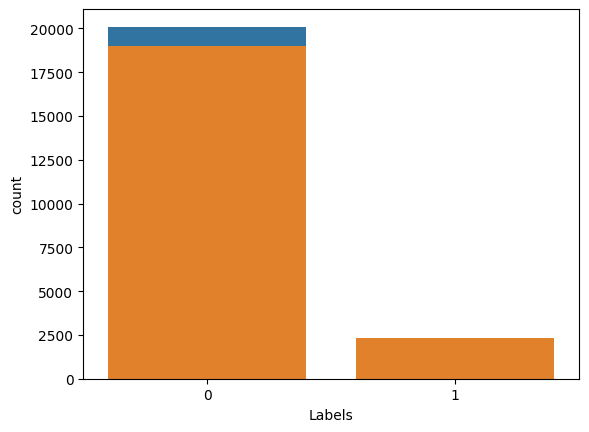

In [ ]:
for dd in range(3,5):
    ecg_data=pd.read_csv('ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv')
    temp = [
        [1,0,0,0,0],
        [0,1,0,0,0],
        [0,0,1,0,0],
        [0,0,0,1,0],
        [0,0,0,0,1]
    ]

    #Merging the diagnosis into a superclass:
    labels=[]
    discard=[]
    for index in range(ecg_data.shape[0]):
        counter=0
        temp_diag=ecg_data['scp_codes'][index]
        temp_diag=re.sub('{',"",str(temp_diag))
        temp_diag=re.sub('}',"",temp_diag)
        temp_diag=temp_diag.split(',')
        len_diag=len(temp_diag)
        for idx in range(len_diag):
            temp_d=temp_diag[idx]
            temp_d=temp_d.split(':')[0]
            temp_d=re.sub(r'[^\w\s]',"",temp_d)
            if temp_d in diagnostics['NORM']:
                label=temp[dd][0]
                counter=1
            elif temp_d in diagnostics['STTC']:
                label=temp[dd][1]
                counter=1
            elif temp_d in diagnostics['MI']:
                label=temp[dd][2]
                counter=1
            elif temp_d in diagnostics['HYP']:
                label=temp[dd][3]
                counter=1
            elif temp_d in diagnostics['CD']:
                label=temp[dd][4]
                counter=1
            elif temp_d in diagnostics['OTHER']:
                label=100
            else:
                label=100
            labels.append(label)
        if counter==0:
            discard.append(index)

    final_labels=[]
    for index in range(len(labels)):
        if labels[index]!=100:
            final_labels.append(labels[index])

    final_data=ecg_data.drop(axis=0,index=discard)
    final_data['Labels']=final_labels
    sns.countplot(data=final_data,x='Labels')
    ECG_train = final_data[final_data['strat_fold'].isin([1, 2, 3, 4, 5, 6, 7, 8])].reset_index(drop=True)
    ECG_val = final_data[final_data['strat_fold'] == 9].reset_index(drop=True)
    ECG_test = final_data[final_data['strat_fold'] == 10].reset_index(drop=True)

    ECG_train = ECG_train[ECG_train['Labels'].isin([0,1])].reset_index(drop=True)
    ECG_val = ECG_val[ECG_val['Labels'].isin([0,1])].reset_index(drop=True)
    ECG_test = ECG_test[ECG_test['Labels'].isin([0,1])].reset_index(drop=True)

    # ECG_train=ECG_train.reset_index()
    # ECG_test=ECG_test.reset_index()
    class_0_count = (ECG_train['Labels'] == 0).sum()
    class_1_count = (ECG_train['Labels'] == 1).sum()

    print("Class 0 count in ECG_train:", class_0_count)
    print("Class 1 count in ECG_train:", class_1_count)

    import torch

    # 각 클래스의 데이터 개수 세기
    class_counts = {
        0: class_0_count,
        1: class_1_count
    }

    # 클래스의 비율 계산
    total_samples = sum(class_counts.values())
    class_ratios = {class_label: count / total_samples for class_label, count in class_counts.items()}

    # weight 계산
    class_weights = {class_label: 1.0 / ratio for class_label, ratio in class_ratios.items()}

    # weight를 tensor로 변환
    weight_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float)

    print("Class weights:", class_weights)
    print("Weight tensor:", weight_tensor)

    train_dataset = ECG_Data(ECG_train)
    train_loader = DataLoader(train_dataset,batch_size=64, shuffle=True)

    val_dataset=ECG_Data(ECG_val)
    val_loader=DataLoader(val_dataset,batch_size=64, shuffle=True)

    test_dataset=ECG_Data(ECG_test)
    test_loader=DataLoader(test_dataset,batch_size=64, shuffle=True)

    first_batch, label = next(iter(train_loader))

    print(f"Batch shape: {first_batch.shape}")

    print(len(train_loader), len(val_loader), len(test_loader))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {device} device")
    num_epochs = 30
    tau = 2
    #model = BCResNets(int(tau * 8), 5).to(device)
    in_channel = 12
    best_test_auc = float("-inf")

    model = BCResNets(int(tau * 8), 1, in_channel).to(device)
    #model.load_state_dict(torch.load('/content/drive/MyDrive/bcresnet3_best_weights_5.pth'))

    """
    torch.save({
        'model_state_dict': model.state_dict(),
        'classifier_state_dict': model.classifier.state_dict()
    }, 'model_checkpoint.pth')
    checkpoint = torch.load('model_checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    num_classes = 1
    # classifier 부분 수정
    model.classifier = nn.Sequential(
        nn.Conv2d(
            model.c[-2], model.c[-2], (5, 5), bias=False, groups=model.c[-2], padding=(0, 2)
        ),
        nn.Conv2d(model.c[-2], model.c[-1], 1, bias=False),
        nn.BatchNorm2d(model.c[-1]),
        nn.ReLU(True),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Conv2d(model.c[-1], num_classes, 1),
    )
    """
    #print(model)
    model = model.to(device)
    total_iter = len(train_loader) * num_epochs
    iterations = 0
    init_lr = 1e-2
    lr_lower_limit = 0

    optim = torch.optim.Adam(model.parameters(), lr=init_lr)
    #loss_fn = torch.nn.CrossEntropyLoss(class_weights)
    loss_fn = torch.nn.BCELoss(weight=weight_tensor[1].float().to(device))
    #loss_fn = torch.nn.CrossEntropyLoss()

    def acc(op, labels):
        op = torch.softmax(op, dim=1)
        _, preds = torch.max(op, dim=1)
        return (preds == labels).float().mean()

    for epoch in range(num_epochs):
        model.train()
        train_accuracy = []
        train_loss_sum = 0
        for data, label in train_loader:

            data, label = data.to(device), label.to(device)

            optim.zero_grad()
            output = model(data)
            loss_value = loss_fn(torch.sigmoid(output).squeeze(-1).float(), label.float())
            loss_value.backward()
            optim.step()

            train_loss_sum += loss_value.item()
            train_accuracy.append(acc(output, label).item())

        avg_train_accuracy = np.mean(train_accuracy)
        avg_train_loss = train_loss_sum / len(train_loader)
        print(f'Epoch: {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.2f}%')

        model.eval()
        test_accuracy = []
        test_loss_sum = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for data, label in test_loader:
                data, label = data.to(device), label.to(device)

                output = model(data)
                loss_value = loss_fn(torch.sigmoid(output).squeeze(-1).float(), label.float())

                test_loss_sum += loss_value.item()
                test_accuracy.append(acc(output, label).item())

                y_true.extend(label.cpu().numpy())
                y_pred.extend(torch.sigmoid(output).cpu().numpy())

        avg_test_accuracy = np.mean(test_accuracy)
        avg_test_loss = test_loss_sum / len(test_loader)
        print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.2f}%')

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # Calculate macro AUC
        macro_auc_ovo = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovo')
        macro_auc_ovr = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')
        if macro_auc_ovr > best_test_auc:
          torch.save(model.state_dict(), f'{dd}model.pth')
        print(f'Macro AUC: {macro_auc_ovo:.4f}, {macro_auc_ovr:.4f}')

Class 0 count in ECG_train: 16038
Class 1 count in ECG_train: 1003
Class weights: {0: 1.0625389699463772, 1: 16.990029910269193}
Weight tensor: tensor([ 1.0625, 16.9900])
Batch shape: torch.Size([64, 12, 1000])
267 34 34
Using cuda device
Epoch: 1/30, Training Loss: 2.7532, Training Accuracy: 0.94%
Test Loss: 2.6059, Test Accuracy: 0.95%
Macro AUC: 0.8887, 0.8887
Epoch: 2/30, Training Loss: 2.3562, Training Accuracy: 0.94%
Test Loss: 2.9938, Test Accuracy: 0.95%
Macro AUC: 0.8820, 0.8820
Epoch: 3/30, Training Loss: 2.2925, Training Accuracy: 0.94%
Test Loss: 2.7117, Test Accuracy: 0.95%
Macro AUC: 0.8834, 0.8834
Epoch: 4/30, Training Loss: 2.2948, Training Accuracy: 0.94%
Test Loss: 2.8325, Test Accuracy: 0.95%
Macro AUC: 0.8934, 0.8934
Epoch: 5/30, Training Loss: 2.2301, Training Accuracy: 0.94%
Test Loss: 2.6772, Test Accuracy: 0.95%
Macro AUC: 0.8893, 0.8893
Epoch: 6/30, Training Loss: 2.2212, Training Accuracy: 0.94%
Test Loss: 2.7160, Test Accuracy: 0.95%
Macro AUC: 0.8904, 0.8904

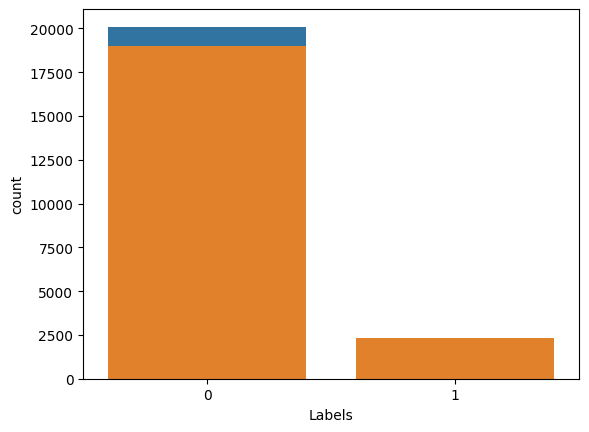

In [ ]:
for dd in range(3,5):
    ecg_data=pd.read_csv('ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv')
    temp = [
        [1,0,0,0,0],
        [0,1,0,0,0],
        [0,0,1,0,0],
        [0,0,0,1,0],
        [0,0,0,0,1]
    ]

    #Merging the diagnosis into a superclass:
    labels=[]
    discard=[]
    for index in range(ecg_data.shape[0]):
        counter=0
        temp_diag=ecg_data['scp_codes'][index]
        temp_diag=re.sub('{',"",str(temp_diag))
        temp_diag=re.sub('}',"",temp_diag)
        temp_diag=temp_diag.split(',')
        len_diag=len(temp_diag)
        for idx in range(len_diag):
            temp_d=temp_diag[idx]
            temp_d=temp_d.split(':')[0]
            temp_d=re.sub(r'[^\w\s]',"",temp_d)
            if temp_d in diagnostics['NORM']:
                label=temp[dd][0]
                counter=1
            elif temp_d in diagnostics['STTC']:
                label=temp[dd][1]
                counter=1
            elif temp_d in diagnostics['MI']:
                label=temp[dd][2]
                counter=1
            elif temp_d in diagnostics['HYP']:
                label=temp[dd][3]
                counter=1
            elif temp_d in diagnostics['CD']:
                label=temp[dd][4]
                counter=1
            elif temp_d in diagnostics['OTHER']:
                label=100
            else:
                label=100
            labels.append(label)
        if counter==0:
            discard.append(index)

    final_labels=[]
    for index in range(len(labels)):
        if labels[index]!=100:
            final_labels.append(labels[index])

    final_data=ecg_data.drop(axis=0,index=discard)
    final_data['Labels']=final_labels
    sns.countplot(data=final_data,x='Labels')
    ECG_train = final_data[final_data['strat_fold'].isin([1, 2, 3, 4, 5, 6, 7, 8])].reset_index(drop=True)
    ECG_val = final_data[final_data['strat_fold'] == 9].reset_index(drop=True)
    ECG_test = final_data[final_data['strat_fold'] == 10].reset_index(drop=True)

    ECG_train = ECG_train[ECG_train['Labels'].isin([0,1])].reset_index(drop=True)
    ECG_val = ECG_val[ECG_val['Labels'].isin([0,1])].reset_index(drop=True)
    ECG_test = ECG_test[ECG_test['Labels'].isin([0,1])].reset_index(drop=True)

    # ECG_train=ECG_train.reset_index()
    # ECG_test=ECG_test.reset_index()
    class_0_count = (ECG_train['Labels'] == 0).sum()
    class_1_count = (ECG_train['Labels'] == 1).sum()

    print("Class 0 count in ECG_train:", class_0_count)
    print("Class 1 count in ECG_train:", class_1_count)

    import torch

    # 각 클래스의 데이터 개수 세기
    class_counts = {
        0: class_0_count,
        1: class_1_count
    }

    # 클래스의 비율 계산
    total_samples = sum(class_counts.values())
    class_ratios = {class_label: count / total_samples for class_label, count in class_counts.items()}

    # weight 계산
    class_weights = {class_label: 1.0 / ratio for class_label, ratio in class_ratios.items()}

    # weight를 tensor로 변환
    weight_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float)

    print("Class weights:", class_weights)
    print("Weight tensor:", weight_tensor)

    train_dataset = ECG_Data(ECG_train)
    train_loader = DataLoader(train_dataset,batch_size=64, shuffle=True)

    val_dataset=ECG_Data(ECG_val)
    val_loader=DataLoader(val_dataset,batch_size=64, shuffle=True)

    test_dataset=ECG_Data(ECG_test)
    test_loader=DataLoader(test_dataset,batch_size=64, shuffle=True)

    first_batch, label = next(iter(train_loader))

    print(f"Batch shape: {first_batch.shape}")

    print(len(train_loader), len(val_loader), len(test_loader))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {device} device")
    num_epochs = 30
    tau = 2
    #model = BCResNets(int(tau * 8), 5).to(device)
    in_channel = 12
    best_test_auc = float("-inf")

    model = BCResNets(int(tau * 8), 1, in_channel).to(device)
    #model.load_state_dict(torch.load('/content/drive/MyDrive/bcresnet3_best_weights_5.pth'))

    """
    torch.save({
        'model_state_dict': model.state_dict(),
        'classifier_state_dict': model.classifier.state_dict()
    }, 'model_checkpoint.pth')
    checkpoint = torch.load('model_checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    num_classes = 1
    # classifier 부분 수정
    model.classifier = nn.Sequential(
        nn.Conv2d(
            model.c[-2], model.c[-2], (5, 5), bias=False, groups=model.c[-2], padding=(0, 2)
        ),
        nn.Conv2d(model.c[-2], model.c[-1], 1, bias=False),
        nn.BatchNorm2d(model.c[-1]),
        nn.ReLU(True),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Conv2d(model.c[-1], num_classes, 1),
    )
    """
    #print(model)
    model = model.to(device)
    total_iter = len(train_loader) * num_epochs
    iterations = 0
    init_lr = 1e-2
    lr_lower_limit = 0

    optim = torch.optim.Adam(model.parameters(), lr=init_lr)
    #loss_fn = torch.nn.CrossEntropyLoss(class_weights)
    loss_fn = torch.nn.BCELoss(weight=weight_tensor[1].float().to(device))
    #loss_fn = torch.nn.CrossEntropyLoss()

    def acc(op, labels):
        op = torch.softmax(op, dim=1)
        _, preds = torch.max(op, dim=1)
        return (preds == labels).float().mean()

    for epoch in range(num_epochs):
        model.train()
        train_accuracy = []
        train_loss_sum = 0
        for data, label in train_loader:

            data, label = data.to(device), label.to(device)

            optim.zero_grad()
            output = model(data)
            loss_value = loss_fn(torch.sigmoid(output).squeeze(-1).float(), label.float())
            loss_value.backward()
            optim.step()

            train_loss_sum += loss_value.item()
            train_accuracy.append(acc(output, label).item())

        avg_train_accuracy = np.mean(train_accuracy)
        avg_train_loss = train_loss_sum / len(train_loader)
        print(f'Epoch: {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.2f}%')

        model.eval()
        test_accuracy = []
        test_loss_sum = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for data, label in test_loader:
                data, label = data.to(device), label.to(device)

                output = model(data)
                loss_value = loss_fn(torch.sigmoid(output).squeeze(-1).float(), label.float())

                test_loss_sum += loss_value.item()
                test_accuracy.append(acc(output, label).item())

                y_true.extend(label.cpu().numpy())
                y_pred.extend(torch.sigmoid(output).cpu().numpy())

        avg_test_accuracy = np.mean(test_accuracy)
        avg_test_loss = test_loss_sum / len(test_loader)
        print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.2f}%')

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # Calculate macro AUC
        macro_auc_ovo = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovo')
        macro_auc_ovr = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')
        if macro_auc_ovr > best_test_auc:
          torch.save(model.state_dict(), f'{dd}model.pth')
        print(f'Macro AUC: {macro_auc_ovo:.4f}, {macro_auc_ovr:.4f}')

Class 0 count in ECG_train: 16038
Class 1 count in ECG_train: 1003
Class weights: {0: 1.0625389699463772, 1: 16.990029910269193}
Weight tensor: tensor([ 1.0625, 16.9900])
Batch shape: torch.Size([64, 12, 1000])
267 34 34
Using cuda device
Epoch: 1/30, Training Loss: 2.7512, Training Accuracy: 0.94%
Test Loss: 2.7139, Test Accuracy: 0.95%
Macro AUC: 0.8856, 0.8856
Epoch: 2/30, Training Loss: 2.3546, Training Accuracy: 0.94%
Test Loss: 2.9091, Test Accuracy: 0.95%
Macro AUC: 0.8928, 0.8928
Epoch: 3/30, Training Loss: 2.3239, Training Accuracy: 0.94%
Test Loss: 2.7575, Test Accuracy: 0.95%
Macro AUC: 0.8908, 0.8908
Epoch: 4/30, Training Loss: 2.2637, Training Accuracy: 0.94%
Test Loss: 2.8619, Test Accuracy: 0.95%
Macro AUC: 0.8973, 0.8973
Epoch: 5/30, Training Loss: 2.1801, Training Accuracy: 0.94%
Test Loss: 2.6920, Test Accuracy: 0.95%
Macro AUC: 0.8764, 0.8764
Epoch: 6/30, Training Loss: 2.1797, Training Accuracy: 0.94%
Test Loss: 2.6773, Test Accuracy: 0.95%
Macro AUC: 0.9027, 0.9027

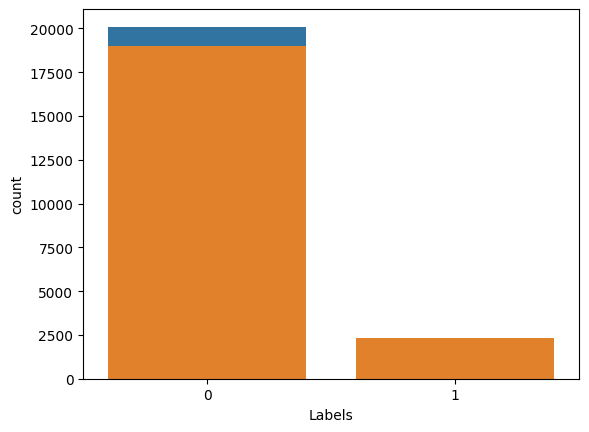

In [ ]:
for dd in range(3,5):
    ecg_data=pd.read_csv('ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv')
    temp = [
        [1,0,0,0,0],
        [0,1,0,0,0],
        [0,0,1,0,0],
        [0,0,0,1,0],
        [0,0,0,0,1]
    ]

    #Merging the diagnosis into a superclass:
    labels=[]
    discard=[]
    for index in range(ecg_data.shape[0]):
        counter=0
        temp_diag=ecg_data['scp_codes'][index]
        temp_diag=re.sub('{',"",str(temp_diag))
        temp_diag=re.sub('}',"",temp_diag)
        temp_diag=temp_diag.split(',')
        len_diag=len(temp_diag)
        for idx in range(len_diag):
            temp_d=temp_diag[idx]
            temp_d=temp_d.split(':')[0]
            temp_d=re.sub(r'[^\w\s]',"",temp_d)
            if temp_d in diagnostics['NORM']:
                label=temp[dd][0]
                counter=1
            elif temp_d in diagnostics['STTC']:
                label=temp[dd][1]
                counter=1
            elif temp_d in diagnostics['MI']:
                label=temp[dd][2]
                counter=1
            elif temp_d in diagnostics['HYP']:
                label=temp[dd][3]
                counter=1
            elif temp_d in diagnostics['CD']:
                label=temp[dd][4]
                counter=1
            elif temp_d in diagnostics['OTHER']:
                label=100
            else:
                label=100
            labels.append(label)
        if counter==0:
            discard.append(index)

    final_labels=[]
    for index in range(len(labels)):
        if labels[index]!=100:
            final_labels.append(labels[index])

    final_data=ecg_data.drop(axis=0,index=discard)
    final_data['Labels']=final_labels
    sns.countplot(data=final_data,x='Labels')
    ECG_train = final_data[final_data['strat_fold'].isin([1, 2, 3, 4, 5, 6, 7, 8])].reset_index(drop=True)
    ECG_val = final_data[final_data['strat_fold'] == 9].reset_index(drop=True)
    ECG_test = final_data[final_data['strat_fold'] == 10].reset_index(drop=True)

    ECG_train = ECG_train[ECG_train['Labels'].isin([0,1])].reset_index(drop=True)
    ECG_val = ECG_val[ECG_val['Labels'].isin([0,1])].reset_index(drop=True)
    ECG_test = ECG_test[ECG_test['Labels'].isin([0,1])].reset_index(drop=True)

    # ECG_train=ECG_train.reset_index()
    # ECG_test=ECG_test.reset_index()
    class_0_count = (ECG_train['Labels'] == 0).sum()
    class_1_count = (ECG_train['Labels'] == 1).sum()

    print("Class 0 count in ECG_train:", class_0_count)
    print("Class 1 count in ECG_train:", class_1_count)

    import torch

    # 각 클래스의 데이터 개수 세기
    class_counts = {
        0: class_0_count,
        1: class_1_count
    }

    # 클래스의 비율 계산
    total_samples = sum(class_counts.values())
    class_ratios = {class_label: count / total_samples for class_label, count in class_counts.items()}

    # weight 계산
    class_weights = {class_label: 1.0 / ratio for class_label, ratio in class_ratios.items()}

    # weight를 tensor로 변환
    weight_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float)

    print("Class weights:", class_weights)
    print("Weight tensor:", weight_tensor)

    train_dataset = ECG_Data(ECG_train)
    train_loader = DataLoader(train_dataset,batch_size=64, shuffle=True)

    val_dataset=ECG_Data(ECG_val)
    val_loader=DataLoader(val_dataset,batch_size=64, shuffle=True)

    test_dataset=ECG_Data(ECG_test)
    test_loader=DataLoader(test_dataset,batch_size=64, shuffle=True)

    first_batch, label = next(iter(train_loader))

    print(f"Batch shape: {first_batch.shape}")

    print(len(train_loader), len(val_loader), len(test_loader))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {device} device")
    num_epochs = 30
    tau = 2
    #model = BCResNets(int(tau * 8), 5).to(device)
    in_channel = 12
    best_test_auc = float("-inf")

    model = BCResNets(int(tau * 8), 1, in_channel).to(device)
    #model.load_state_dict(torch.load('/content/drive/MyDrive/bcresnet3_best_weights_5.pth'))

    """
    torch.save({
        'model_state_dict': model.state_dict(),
        'classifier_state_dict': model.classifier.state_dict()
    }, 'model_checkpoint.pth')
    checkpoint = torch.load('model_checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    num_classes = 1
    # classifier 부분 수정
    model.classifier = nn.Sequential(
        nn.Conv2d(
            model.c[-2], model.c[-2], (5, 5), bias=False, groups=model.c[-2], padding=(0, 2)
        ),
        nn.Conv2d(model.c[-2], model.c[-1], 1, bias=False),
        nn.BatchNorm2d(model.c[-1]),
        nn.ReLU(True),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Conv2d(model.c[-1], num_classes, 1),
    )
    """
    #print(model)
    model = model.to(device)
    total_iter = len(train_loader) * num_epochs
    iterations = 0
    init_lr = 1e-2
    lr_lower_limit = 0

    optim = torch.optim.Adam(model.parameters(), lr=init_lr)
    #loss_fn = torch.nn.CrossEntropyLoss(class_weights)
    loss_fn = torch.nn.BCELoss(weight=weight_tensor[1].float().to(device))
    #loss_fn = torch.nn.CrossEntropyLoss()

    def acc(op, labels):
        op = torch.softmax(op, dim=1)
        _, preds = torch.max(op, dim=1)
        return (preds == labels).float().mean()

    for epoch in range(num_epochs):
        model.train()
        train_accuracy = []
        train_loss_sum = 0
        for data, label in train_loader:

            data, label = data.to(device), label.to(device)

            optim.zero_grad()
            output = model(data)
            loss_value = loss_fn(torch.sigmoid(output).squeeze(-1).float(), label.float())
            loss_value.backward()
            optim.step()

            train_loss_sum += loss_value.item()
            train_accuracy.append(acc(output, label).item())

        avg_train_accuracy = np.mean(train_accuracy)
        avg_train_loss = train_loss_sum / len(train_loader)
        print(f'Epoch: {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.2f}%')

        model.eval()
        test_accuracy = []
        test_loss_sum = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for data, label in test_loader:
                data, label = data.to(device), label.to(device)

                output = model(data)
                loss_value = loss_fn(torch.sigmoid(output).squeeze(-1).float(), label.float())

                test_loss_sum += loss_value.item()
                test_accuracy.append(acc(output, label).item())

                y_true.extend(label.cpu().numpy())
                y_pred.extend(torch.sigmoid(output).cpu().numpy())

        avg_test_accuracy = np.mean(test_accuracy)
        avg_test_loss = test_loss_sum / len(test_loader)
        print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.2f}%')

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # Calculate macro AUC
        macro_auc_ovo = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovo')
        macro_auc_ovr = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')
        if macro_auc_ovr > best_test_auc:
          torch.save(model.state_dict(), f'{dd}model.pth')
        print(f'Macro AUC: {macro_auc_ovo:.4f}, {macro_auc_ovr:.4f}')

Class 0 count in ECG_train: 15200
Class 1 count in ECG_train: 1841
Class weights: {0: 1.1211184210526315, 1: 9.256382400869093}
Weight tensor: tensor([1.1211, 9.2564])
Batch shape: torch.Size([64, 12, 1000])
267 34 34
Using cuda device
Epoch: 1/30, Training Loss: 2.3086, Training Accuracy: 0.89%
Test Loss: 2.5688, Test Accuracy: 0.89%
Macro AUC: 0.8547, 0.8547
Epoch: 2/30, Training Loss: 2.0199, Training Accuracy: 0.89%
Test Loss: 2.2041, Test Accuracy: 0.89%
Macro AUC: 0.8714, 0.8714
Epoch: 3/30, Training Loss: 1.9262, Training Accuracy: 0.89%
Test Loss: 2.3272, Test Accuracy: 0.89%
Macro AUC: 0.8724, 0.8724
Epoch: 4/30, Training Loss: 1.8416, Training Accuracy: 0.89%
Test Loss: 2.4283, Test Accuracy: 0.89%
Macro AUC: 0.8870, 0.8870
Epoch: 5/30, Training Loss: 1.7964, Training Accuracy: 0.89%
Test Loss: 2.1693, Test Accuracy: 0.89%
Macro AUC: 0.8883, 0.8883
Epoch: 6/30, Training Loss: 1.7461, Training Accuracy: 0.89%
Test Loss: 2.0610, Test Accuracy: 0.89%
Macro AUC: 0.8961, 0.8961
Ep

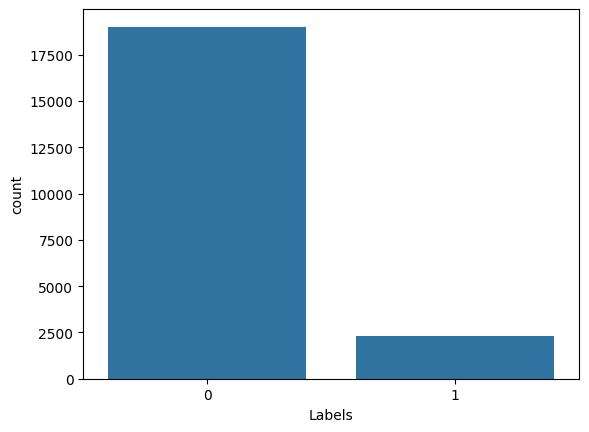

In [ ]:
for dd in range(4,5):
    ecg_data=pd.read_csv('ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv')
    temp = [
        [1,0,0,0,0],
        [0,1,0,0,0],
        [0,0,1,0,0],
        [0,0,0,1,0],
        [0,0,0,0,1]
    ]

    #Merging the diagnosis into a superclass:
    labels=[]
    discard=[]
    for index in range(ecg_data.shape[0]):
        counter=0
        temp_diag=ecg_data['scp_codes'][index]
        temp_diag=re.sub('{',"",str(temp_diag))
        temp_diag=re.sub('}',"",temp_diag)
        temp_diag=temp_diag.split(',')
        len_diag=len(temp_diag)
        for idx in range(len_diag):
            temp_d=temp_diag[idx]
            temp_d=temp_d.split(':')[0]
            temp_d=re.sub(r'[^\w\s]',"",temp_d)
            if temp_d in diagnostics['NORM']:
                label=temp[dd][0]
                counter=1
            elif temp_d in diagnostics['STTC']:
                label=temp[dd][1]
                counter=1
            elif temp_d in diagnostics['MI']:
                label=temp[dd][2]
                counter=1
            elif temp_d in diagnostics['HYP']:
                label=temp[dd][3]
                counter=1
            elif temp_d in diagnostics['CD']:
                label=temp[dd][4]
                counter=1
            elif temp_d in diagnostics['OTHER']:
                label=100
            else:
                label=100
            labels.append(label)
        if counter==0:
            discard.append(index)

    final_labels=[]
    for index in range(len(labels)):
        if labels[index]!=100:
            final_labels.append(labels[index])

    final_data=ecg_data.drop(axis=0,index=discard)
    final_data['Labels']=final_labels
    sns.countplot(data=final_data,x='Labels')
    ECG_train = final_data[final_data['strat_fold'].isin([1, 2, 3, 4, 5, 6, 7, 8])].reset_index(drop=True)
    ECG_val = final_data[final_data['strat_fold'] == 9].reset_index(drop=True)
    ECG_test = final_data[final_data['strat_fold'] == 10].reset_index(drop=True)

    ECG_train = ECG_train[ECG_train['Labels'].isin([0,1])].reset_index(drop=True)
    ECG_val = ECG_val[ECG_val['Labels'].isin([0,1])].reset_index(drop=True)
    ECG_test = ECG_test[ECG_test['Labels'].isin([0,1])].reset_index(drop=True)

    # ECG_train=ECG_train.reset_index()
    # ECG_test=ECG_test.reset_index()
    class_0_count = (ECG_train['Labels'] == 0).sum()
    class_1_count = (ECG_train['Labels'] == 1).sum()

    print("Class 0 count in ECG_train:", class_0_count)
    print("Class 1 count in ECG_train:", class_1_count)

    import torch

    # 각 클래스의 데이터 개수 세기
    class_counts = {
        0: class_0_count,
        1: class_1_count
    }

    # 클래스의 비율 계산
    total_samples = sum(class_counts.values())
    class_ratios = {class_label: count / total_samples for class_label, count in class_counts.items()}

    # weight 계산
    class_weights = {class_label: 1.0 / ratio for class_label, ratio in class_ratios.items()}

    # weight를 tensor로 변환
    weight_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float)

    print("Class weights:", class_weights)
    print("Weight tensor:", weight_tensor)

    train_dataset = ECG_Data(ECG_train)
    train_loader = DataLoader(train_dataset,batch_size=64, shuffle=True)

    val_dataset=ECG_Data(ECG_val)
    val_loader=DataLoader(val_dataset,batch_size=64, shuffle=True)

    test_dataset=ECG_Data(ECG_test)
    test_loader=DataLoader(test_dataset,batch_size=64, shuffle=True)

    first_batch, label = next(iter(train_loader))

    print(f"Batch shape: {first_batch.shape}")

    print(len(train_loader), len(val_loader), len(test_loader))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {device} device")
    num_epochs = 30
    tau = 2
    #model = BCResNets(int(tau * 8), 5).to(device)
    in_channel = 12
    best_test_auc = float("-inf")

    model = BCResNets(int(tau * 8), 1, in_channel).to(device)
    #model.load_state_dict(torch.load('/content/drive/MyDrive/bcresnet3_best_weights_5.pth'))

    """
    torch.save({
        'model_state_dict': model.state_dict(),
        'classifier_state_dict': model.classifier.state_dict()
    }, 'model_checkpoint.pth')
    checkpoint = torch.load('model_checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    num_classes = 1
    # classifier 부분 수정
    model.classifier = nn.Sequential(
        nn.Conv2d(
            model.c[-2], model.c[-2], (5, 5), bias=False, groups=model.c[-2], padding=(0, 2)
        ),
        nn.Conv2d(model.c[-2], model.c[-1], 1, bias=False),
        nn.BatchNorm2d(model.c[-1]),
        nn.ReLU(True),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Conv2d(model.c[-1], num_classes, 1),
    )
    """
    #print(model)
    model = model.to(device)
    total_iter = len(train_loader) * num_epochs
    iterations = 0
    init_lr = 1e-2
    lr_lower_limit = 0

    optim = torch.optim.Adam(model.parameters(), lr=init_lr)
    #loss_fn = torch.nn.CrossEntropyLoss(class_weights)
    loss_fn = torch.nn.BCELoss(weight=weight_tensor[1].float().to(device))
    #loss_fn = torch.nn.CrossEntropyLoss()

    def acc(op, labels):
        op = torch.softmax(op, dim=1)
        _, preds = torch.max(op, dim=1)
        return (preds == labels).float().mean()

    for epoch in range(num_epochs):
        model.train()
        train_accuracy = []
        train_loss_sum = 0
        for data, label in train_loader:

            data, label = data.to(device), label.to(device)

            optim.zero_grad()
            output = model(data)
            loss_value = loss_fn(torch.sigmoid(output).squeeze(-1).float(), label.float())
            loss_value.backward()
            optim.step()

            train_loss_sum += loss_value.item()
            train_accuracy.append(acc(output, label).item())

        avg_train_accuracy = np.mean(train_accuracy)
        avg_train_loss = train_loss_sum / len(train_loader)
        print(f'Epoch: {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.2f}%')

        model.eval()
        test_accuracy = []
        test_loss_sum = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for data, label in test_loader:
                data, label = data.to(device), label.to(device)

                output = model(data)
                loss_value = loss_fn(torch.sigmoid(output).squeeze(-1).float(), label.float())

                test_loss_sum += loss_value.item()
                test_accuracy.append(acc(output, label).item())

                y_true.extend(label.cpu().numpy())
                y_pred.extend(torch.sigmoid(output).cpu().numpy())

        avg_test_accuracy = np.mean(test_accuracy)
        avg_test_loss = test_loss_sum / len(test_loader)
        print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.2f}%')

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # Calculate macro AUC
        macro_auc_ovo = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovo')
        macro_auc_ovr = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')
        if macro_auc_ovr > best_test_auc:
          torch.save(model.state_dict(), f'{dd}model.pth')
        print(f'Macro AUC: {macro_auc_ovo:.4f}, {macro_auc_ovr:.4f}')